# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading Sanity Functions

In [2]:
def sanity_check(model, use_softplus=False, transformation_grad=1):

    model_dict = dict(model.state_dict())
    print(model_dict.keys())

    if not use_softplus:
        a = model.transformation.params[transformation_grad].detach().cpu()
        eps = torch.empty_like(a)
        eps[0] = a[0]
        eps[1:] = torch.nn.functional.softplus(a[1:])
        eps = torch.cumsum(eps, dim=0)
    
    is_mono = torch.all(torch.diff(eps) > 0)
    print(is_mono.item())
        
    print(f"{eps}")  # should be strictly increasing
    plt.plot(range(len(eps)), eps, marker='o')
    plt.title("Monotonic spline coefficients ε_j,p")
    plt.xlabel("Basis index p")
    plt.ylabel("ε_j,p")
    plt.show()

def series(x):
    """Return a 1D numpy array from tensor OR list/tuple of (tensors|floats)."""
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    if isinstance(x, (list, tuple)):
        return np.array([t.detach().cpu().item() if torch.is_tensor(t) else float(t) for t in x])
    return np.asarray(x)

#### Hyperparameter choice

In [3]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    #"RW2": {"tau_a": 1e-3, "tau_b": 1e-3},   # A) nearly-flat proper  ← recommended
    "RW2": {"tau_a": 1.1,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}

# Test 1 ndependence copula + standard Gaussian marginals (N(0,1))

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Independent Copula and add Gaussian marginals.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [4]:
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)


# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

copula_pv_est = pv.Bicop(family=pv.BicopFamily.indep)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

/tmp/ipykernel_303080/815319882.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_303080/815319882.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_303080/815319882.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_t

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=200)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=200)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:
model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ


current_loss: tensor(1.4411, grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<08:59,  1.85it/s]

current_loss: tensor(1.4363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4331,

  0%|          | 2/1000 [00:00<05:24,  3.08it/s]

current_loss: tensor(1.4418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4053, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4038,

  0%|          | 3/1000 [00:00<04:18,  3.85it/s]

current_loss: tensor(1.4045, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4044, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4412,

  0%|          | 4/1000 [00:01<03:53,  4.26it/s]

current_loss: tensor(1.4038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4054, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4030, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4406, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4392,

  0%|          | 5/1000 [00:01<03:40,  4.52it/s]

current_loss: tensor(1.4287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4054, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4395, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4387, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081,

  1%|          | 6/1000 [00:01<03:26,  4.82it/s]

current_loss: tensor(1.3776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4051, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4326, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4396, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4078, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4078, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4078, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4034,

  1%|          | 7/1000 [00:01<03:22,  4.89it/s]

current_loss: tensor(1.4042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4386, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4287,

  1%|          | 8/1000 [00:01<03:19,  4.97it/s]

current_loss: tensor(1.4285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4387, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4385, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4031, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3769,

  1%|          | 9/1000 [00:02<03:13,  5.13it/s]

current_loss: tensor(1.3843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4388, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4386, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4370, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4051, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4046,

  1%|          | 11/1000 [00:02<03:05,  5.34it/s]

current_loss: tensor(1.4319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4389, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4051, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4053, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4286,

  1%|          | 12/1000 [00:02<03:04,  5.37it/s]

current_loss: tensor(1.4393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4380, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4040, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4054, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4044, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3851, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4325,

  1%|▏         | 13/1000 [00:02<03:02,  5.41it/s]

current_loss: tensor(1.4080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022,

  1%|▏         | 13/1000 [00:02<03:44,  4.40it/s]

current_loss: tensor(1.4051, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4046, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, grad_fn=<MeanBackward0>)
Early Stop at iteration 13 with minimal loss tensor(1.4319, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [7]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True


output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=16,            # will ramp
                mcmc_sample_val=64,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.00001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.1,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=12, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 3,
                warm_sigma_epochs = 5,  # try 5–10
                
                #Optimization method
                beta_kl_start= 3,    # try 1.5–3.0
                beta_kl_anneal_epochs = 20,  # how fast to decay to 1.0
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=2000  current B=200  (training objective uses scaled likelihood & unscaled prior)


  0%|          | 1/200 [00:09<32:09,  9.69s/it]

IMPROVED! Congrats
[1/200] ELBO train=1018.0335  val_ELPD=-0.0075  train_ELPD=-0.0073  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈1.02e+03  tau4=0.604919  rank=20  E_qf_mean≈18.3  E_qf_total≈36.7  tau*E_qf≈22.2  target≈22.2  resid≈-2.03e+05    tau4_mean=0.605   Elog_tau=-0.548    â=11.1     b̂=18.3  Δ=-1.11e+04      KL(qτ||pτ)≈0.00411     β_KL=3.00  


  1%|          | 2/200 [00:17<27:47,  8.42s/it]

IMPROVED! Congrats
[2/200] ELBO train=0.7409  val_ELPD=-0.0074  train_ELPD=-0.0074  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.119  tau4=0.630022  rank=20  E_qf_mean≈17.6  E_qf_total≈35.2  tau*E_qf≈22.2  target≈22.2  resid≈0.442    tau4_mean=0.63   Elog_tau=-0.508    â=11.1     b̂=17.6  Δ=+2.51e-02      KL(qτ||pτ)≈0.00396     β_KL=2.90  


  2%|▏         | 3/200 [00:24<26:17,  8.01s/it]

NOT IMPROVED! Nr. 1
[3/200] ELBO train=0.7386  val_ELPD=-0.0075  train_ELPD=-0.0074  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.115  tau4=0.64842  rank=20  E_qf_mean≈17.1  E_qf_total≈34.2  tau*E_qf≈22.2  target≈22.2  resid≈0.315    tau4_mean=0.648   Elog_tau=-0.479    â=11.1     b̂=17.1  Δ=+1.84e-02      KL(qτ||pτ)≈0.00394     β_KL=2.80  


  2%|▏         | 4/200 [00:33<26:50,  8.21s/it]

NOT IMPROVED! Nr. 2
[4/200] ELBO train=0.6983  val_ELPD=-0.0074  train_ELPD=-0.0074  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.111  tau4=0.669988  rank=20  E_qf_mean≈16.6  E_qf_total≈33.1  tau*E_qf≈22.2  target≈22.2  resid≈0.357    tau4_mean=0.67   Elog_tau=-0.446    â=11.1     b̂=16.6  Δ=+2.16e-02      KL(qτ||pτ)≈0.00392     β_KL=2.70  


  2%|▎         | 5/200 [00:40<25:52,  7.96s/it]

NOT IMPROVED! Nr. 3
[5/200] ELBO train=0.6773  val_ELPD=-0.0074  train_ELPD=-0.0073  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.109  tau4=0.694771  rank=20  E_qf_mean≈16  E_qf_total≈32  tau*E_qf≈22.2  target≈22.2  resid≈0.396    tau4_mean=0.695   Elog_tau=-0.41    â=11.1     b̂=16  Δ=+2.48e-02      KL(qτ||pτ)≈0.0039     β_KL=2.60  


  3%|▎         | 6/200 [00:49<26:22,  8.16s/it]

NOT IMPROVED! Nr. 4
[6/200] ELBO train=0.6515  val_ELPD=-0.0074  train_ELPD=-0.0073  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0505 σmin=0.0505 σmax=0.0505  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.106  tau4=0.718602  rank=20  E_qf_mean≈15.4  E_qf_total≈30.9  tau*E_qf≈22.2  target≈22.2  resid≈0.368    tau4_mean=0.719   Elog_tau=-0.376    â=11.1     b̂=15.4  Δ=+2.38e-02      KL(qτ||pτ)≈0.00388     β_KL=2.50  


  4%|▎         | 7/200 [00:57<26:35,  8.26s/it]

NOT IMPROVED! Nr. 5
[7/200] ELBO train=0.6309  val_ELPD=-0.0074  train_ELPD=-0.0073  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0510 σmin=0.0510 σmax=0.0510  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.103  tau4=0.736797  rank=20  E_qf_mean≈15.1  E_qf_total≈30.1  tau*E_qf≈22.2  target≈22.2  resid≈0.274    tau4_mean=0.737   Elog_tau=-0.351    â=11.1     b̂=15.1  Δ=+1.82e-02      KL(qτ||pτ)≈0.00387     β_KL=2.40  


  4%|▍         | 8/200 [01:05<25:41,  8.03s/it]

NOT IMPROVED! Nr. 6
[8/200] ELBO train=0.6012  val_ELPD=-0.0074  train_ELPD=-0.0073  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0515 σmin=0.0515 σmax=0.0515  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.101  tau4=0.753061  rank=20  E_qf_mean≈14.7  E_qf_total≈29.5  tau*E_qf≈22.2  target≈22.2  resid≈0.24    tau4_mean=0.753   Elog_tau=-0.329    â=11.1     b̂=14.7  Δ=+1.63e-02      KL(qτ||pτ)≈0.00385     β_KL=2.30  


  4%|▍         | 9/200 [01:12<25:02,  7.87s/it]

NOT IMPROVED! Nr. 7
[9/200] ELBO train=0.5928  val_ELPD=-0.0074  train_ELPD=-0.0073  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0520 σmin=0.0520 σmax=0.0520  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0993  tau4=0.770137  rank=20  E_qf_mean≈14.4  E_qf_total≈28.8  tau*E_qf≈22.2  target≈22.2  resid≈0.246    tau4_mean=0.77   Elog_tau=-0.307    â=11.1     b̂=14.4  Δ=+1.71e-02      KL(qτ||pτ)≈0.00384     β_KL=2.20  


  5%|▌         | 10/200 [01:20<24:34,  7.76s/it]

NOT IMPROVED! Nr. 8
[10/200] ELBO train=0.5640  val_ELPD=-0.0074  train_ELPD=-0.0073  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0525 σmin=0.0525 σmax=0.0525  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.097  tau4=0.788809  rank=20  E_qf_mean≈14.1  E_qf_total≈28.1  tau*E_qf≈22.2  target≈22.2  resid≈0.263    tau4_mean=0.789   Elog_tau=-0.283    â=11.1     b̂=14.1  Δ=+1.87e-02      KL(qτ||pτ)≈0.00383     β_KL=2.10  


  6%|▌         | 11/200 [01:27<24:13,  7.69s/it]

NOT IMPROVED! Nr. 9
[11/200] ELBO train=0.5353  val_ELPD=-0.0074  train_ELPD=-0.0073  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0530 σmin=0.0530 σmax=0.0530  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0943  tau4=0.8097  rank=20  E_qf_mean≈13.7  E_qf_total≈27.4  tau*E_qf≈22.2  target≈22.2  resid≈0.286    tau4_mean=0.81   Elog_tau=-0.257    â=11.1     b̂=13.7  Δ=+2.09e-02      KL(qτ||pτ)≈0.00382     β_KL=2.00  


  6%|▌         | 12/200 [01:35<23:55,  7.64s/it]

NOT IMPROVED! Nr. 10
[12/200] ELBO train=0.5180  val_ELPD=-0.0074  train_ELPD=-0.0073  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0535 σmin=0.0535 σmax=0.0535  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0914  tau4=0.833377  rank=20  E_qf_mean≈13.3  E_qf_total≈26.6  tau*E_qf≈22.2  target≈22.2  resid≈0.315    tau4_mean=0.833   Elog_tau=-0.228    â=11.1     b̂=13.3  Δ=+2.37e-02      KL(qτ||pτ)≈0.0038     β_KL=1.90  


  6%|▋         | 13/200 [01:42<23:41,  7.60s/it]

NOT IMPROVED! Nr. 11
[13/200] ELBO train=0.4903  val_ELPD=-0.0075  train_ELPD=-0.0073  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0540 σmin=0.0540 σmax=0.0540  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0882  tau4=0.860197  rank=20  E_qf_mean≈12.9  E_qf_total≈25.8  tau*E_qf≈22.2  target≈22.2  resid≈0.346    tau4_mean=0.86   Elog_tau=-0.196    â=11.1     b̂=12.9  Δ=+2.68e-02      KL(qτ||pτ)≈0.00378     β_KL=1.80  


  7%|▋         | 14/200 [01:50<23:29,  7.58s/it]

NOT IMPROVED! Nr. 12
[14/200] ELBO train=0.4677  val_ELPD=-0.0075  train_ELPD=-0.0074  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0545 σmin=0.0545 σmax=0.0545  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0847  tau4=0.890748  rank=20  E_qf_mean≈12.5  E_qf_total≈24.9  tau*E_qf≈22.2  target≈22.2  resid≈0.381    tau4_mean=0.891   Elog_tau=-0.161    â=11.1     b̂=12.5  Δ=+3.06e-02      KL(qτ||pτ)≈0.00377     β_KL=1.70  


  8%|▊         | 15/200 [01:57<23:19,  7.56s/it]

NOT IMPROVED! Nr. 13
[15/200] ELBO train=0.4415  val_ELPD=-0.0075  train_ELPD=-0.0074  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0550 σmin=0.0550 σmax=0.0550  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0808  tau4=0.925518  rank=20  E_qf_mean≈12  E_qf_total≈24  tau*E_qf≈22.2  target≈22.2  resid≈0.417    tau4_mean=0.926   Elog_tau=-0.123    â=11.1     b̂=12  Δ=+3.48e-02      KL(qτ||pτ)≈0.00375     β_KL=1.60  


  8%|▊         | 16/200 [02:05<23:09,  7.55s/it]

NOT IMPROVED! Nr. 14
[16/200] ELBO train=0.4227  val_ELPD=-0.0075  train_ELPD=-0.0074  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0554 σmin=0.0554 σmax=0.0554  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0774  tau4=0.959672  rank=20  E_qf_mean≈11.6  E_qf_total≈23.1  tau*E_qf≈22.2  target≈22.2  resid≈0.395    tau4_mean=0.96   Elog_tau=-0.0869    â=11.1     b̂=11.6  Δ=+3.42e-02      KL(qτ||pτ)≈0.00373     β_KL=1.50  


  8%|▊         | 17/200 [02:13<23:00,  7.54s/it]

NOT IMPROVED! Nr. 15
[17/200] ELBO train=0.3990  val_ELPD=-0.0075  train_ELPD=-0.0074  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0558 σmin=0.0558 σmax=0.0558  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0746  tau4=0.990886  rank=20  E_qf_mean≈11.2  E_qf_total≈22.4  tau*E_qf≈22.2  target≈22.2  resid≈0.35    tau4_mean=0.991   Elog_tau=-0.0549    â=11.1     b̂=11.2  Δ=+3.12e-02      KL(qτ||pτ)≈0.00371     β_KL=1.40  


  9%|▉         | 18/200 [02:20<22:51,  7.54s/it]

NOT IMPROVED! Nr. 16
[18/200] ELBO train=0.3768  val_ELPD=-0.0075  train_ELPD=-0.0074  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0561 σmin=0.0561 σmax=0.0561  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0711  tau4=1.02605  rank=20  E_qf_mean≈10.8  E_qf_total≈21.6  tau*E_qf≈22.2  target≈22.2  resid≈0.38    tau4_mean=1.03   Elog_tau=-0.02    â=11.1     b̂=10.8  Δ=+3.52e-02      KL(qτ||pτ)≈0.00369     β_KL=1.30  


 10%|▉         | 19/200 [02:28<22:43,  7.53s/it]

NOT IMPROVED! Nr. 17
[19/200] ELBO train=0.3560  val_ELPD=-0.0075  train_ELPD=-0.0074  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0565 σmin=0.0565 σmax=0.0565  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0675  tau4=1.06554  rank=20  E_qf_mean≈10.4  E_qf_total≈20.8  tau*E_qf≈22.2  target≈22.2  resid≈0.411    tau4_mean=1.07   Elog_tau=0.0178    â=11.1     b̂=10.4  Δ=+3.95e-02      KL(qτ||pτ)≈0.00367     β_KL=1.20  


 10%|█         | 20/200 [02:35<22:35,  7.53s/it]

NOT IMPROVED! Nr. 18
[20/200] ELBO train=0.3325  val_ELPD=-0.0075  train_ELPD=-0.0074  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0568 σmin=0.0568 σmax=0.0568  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0636  tau4=1.10958  rank=20  E_qf_mean≈10  E_qf_total≈20  tau*E_qf≈22.2  target≈22.2  resid≈0.441    tau4_mean=1.11   Elog_tau=0.0583    â=11.1     b̂=10  Δ=+4.40e-02      KL(qτ||pτ)≈0.00365     β_KL=1.10  


 10%|█         | 21/200 [02:43<22:27,  7.53s/it]

NOT IMPROVED! Nr. 19
[21/200] ELBO train=0.3127  val_ELPD=-0.0075  train_ELPD=-0.0074  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0571 σmin=0.0571 σmax=0.0571  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0594  tau4=1.15884  rank=20  E_qf_mean≈9.58  E_qf_total≈19.2  tau*E_qf≈22.2  target≈22.2  resid≈0.472    tau4_mean=1.16   Elog_tau=0.102    â=11.1     b̂=9.58  Δ=+4.93e-02      KL(qτ||pτ)≈0.00363     β_KL=1.00  


 11%|█         | 22/200 [02:50<22:20,  7.53s/it]

NOT IMPROVED! Nr. 20
[22/200] ELBO train=0.3045  val_ELPD=-0.0075  train_ELPD=-0.0074  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0575 σmin=0.0574 σmax=0.0575  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0551  tau4=1.21327  rank=20  E_qf_mean≈9.15  E_qf_total≈18.3  tau*E_qf≈22.2  target≈22.2  resid≈0.498    tau4_mean=1.21   Elog_tau=0.148    â=11.1     b̂=9.15  Δ=+5.44e-02      KL(qτ||pτ)≈0.0036     β_KL=1.00  


 12%|█▏        | 23/200 [02:58<22:12,  7.53s/it]

NOT IMPROVED! Nr. 21
[23/200] ELBO train=0.3022  val_ELPD=-0.0076  train_ELPD=-0.0074  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0578 σmin=0.0578 σmax=0.0578  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0507  tau4=1.27241  rank=20  E_qf_mean≈8.72  E_qf_total≈17.4  tau*E_qf≈22.2  target≈22.2  resid≈0.516    tau4_mean=1.27   Elog_tau=0.195    â=11.1     b̂=8.72  Δ=+5.91e-02      KL(qτ||pτ)≈0.00358     β_KL=1.00  


 12%|█▏        | 24/200 [03:05<22:04,  7.52s/it]

NOT IMPROVED! Nr. 22
[24/200] ELBO train=0.2980  val_ELPD=-0.0076  train_ELPD=-0.0074  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0581 σmin=0.0581 σmax=0.0581  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0462  tau4=1.33555  rank=20  E_qf_mean≈8.31  E_qf_total≈16.6  tau*E_qf≈22.2  target≈22.2  resid≈0.525    tau4_mean=1.34   Elog_tau=0.244    â=11.1     b̂=8.31  Δ=+6.31e-02      KL(qτ||pτ)≈0.00355     β_KL=1.00  


 12%|█▎        | 25/200 [03:13<21:57,  7.53s/it]

NOT IMPROVED! Nr. 23
[25/200] ELBO train=0.2930  val_ELPD=-0.0076  train_ELPD=-0.0075  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0584 σmin=0.0584 σmax=0.0584  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0418  tau4=1.40289  rank=20  E_qf_mean≈7.91  E_qf_total≈15.8  tau*E_qf≈22.2  target≈22.2  resid≈0.533    tau4_mean=1.4   Elog_tau=0.293    â=11.1     b̂=7.91  Δ=+6.73e-02      KL(qτ||pτ)≈0.00353     β_KL=1.00  


 13%|█▎        | 26/200 [03:20<21:49,  7.53s/it]

NOT IMPROVED! Nr. 24
[26/200] ELBO train=0.2852  val_ELPD=-0.0076  train_ELPD=-0.0075  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0588 σmin=0.0587 σmax=0.0588  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0374  tau4=1.47434  rank=20  E_qf_mean≈7.53  E_qf_total≈15.1  tau*E_qf≈22.2  target≈22.2  resid≈0.538    tau4_mean=1.47   Elog_tau=0.342    â=11.1     b̂=7.53  Δ=+7.15e-02      KL(qτ||pτ)≈0.0035     β_KL=1.00  


 14%|█▎        | 27/200 [03:28<21:41,  7.52s/it]

NOT IMPROVED! Nr. 25
[27/200] ELBO train=0.2791  val_ELPD=-0.0076  train_ELPD=-0.0075  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0591 σmin=0.0591 σmax=0.0591  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0329  tau4=1.55025  rank=20  E_qf_mean≈7.16  E_qf_total≈14.3  tau*E_qf≈22.2  target≈22.2  resid≈0.544    tau4_mean=1.55   Elog_tau=0.393    â=11.1     b̂=7.16  Δ=+7.59e-02      KL(qτ||pτ)≈0.00347     β_KL=1.00  


 14%|█▍        | 28/200 [03:35<21:33,  7.52s/it]

NOT IMPROVED! Nr. 26
[28/200] ELBO train=0.2749  val_ELPD=-0.0076  train_ELPD=-0.0075  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0594 σmin=0.0594 σmax=0.0594  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0285  tau4=1.63099  rank=20  E_qf_mean≈6.8  E_qf_total≈13.6  tau*E_qf≈22.2  target≈22.2  resid≈0.549    tau4_mean=1.63   Elog_tau=0.443    â=11.1     b̂=6.81  Δ=+8.07e-02      KL(qτ||pτ)≈0.00344     β_KL=1.00  


 14%|█▍        | 29/200 [03:43<21:44,  7.63s/it]

NOT IMPROVED! Nr. 27
[29/200] ELBO train=0.2715  val_ELPD=-0.0077  train_ELPD=-0.0075  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0598 σmin=0.0597 σmax=0.0598  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.024  tau4=1.71678  rank=20  E_qf_mean≈6.46  E_qf_total≈12.9  tau*E_qf≈22.2  target≈22.2  resid≈0.555    tau4_mean=1.72   Elog_tau=0.495    â=11.1     b̂=6.47  Δ=+8.58e-02      KL(qτ||pτ)≈0.00342     β_KL=1.00  


 15%|█▌        | 30/200 [03:53<23:10,  8.18s/it]

NOT IMPROVED! Nr. 28
[30/200] ELBO train=0.2699  val_ELPD=-0.0077  train_ELPD=-0.0075  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0600 σmin=0.0600 σmax=0.0600  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0205  tau4=1.79522  rank=20  E_qf_mean≈6.18  E_qf_total≈12.4  tau*E_qf≈22.2  target≈22.2  resid≈0.485    tau4_mean=1.8   Elog_tau=0.539    â=11.1     b̂=6.18  Δ=+7.84e-02      KL(qτ||pτ)≈0.00339     β_KL=1.00  


 16%|█▌        | 31/200 [04:00<22:40,  8.05s/it]

NOT IMPROVED! Nr. 29
[31/200] ELBO train=0.2653  val_ELPD=-0.0077  train_ELPD=-0.0076  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0602 σmin=0.0602 σmax=0.0602  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0179  tau4=1.86126  rank=20  E_qf_mean≈5.96  E_qf_total≈11.9  tau*E_qf≈22.2  target≈22.2  resid≈0.394    tau4_mean=1.86   Elog_tau=0.576    â=11.1     b̂=5.96  Δ=+6.60e-02      KL(qτ||pτ)≈0.00336     β_KL=1.00  


 16%|█▌        | 31/200 [04:08<22:34,  8.01s/it]

NOT IMPROVED! Nr. 30
[32/200] ELBO train=0.2606  val_ELPD=-0.0077  train_ELPD=-0.0076  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0605 σmin=0.0605 σmax=0.0605  N=2000 B=200 B̄≈200.0  priors/obs: decor≈0 trans≈0.0148  tau4=1.93085  rank=20  E_qf_mean≈5.75  E_qf_total≈11.5  tau*E_qf≈22.2  target≈22.2  resid≈0.4    tau4_mean=1.93   Elog_tau=0.612    â=11.1     b̂=5.75  Δ=+6.96e-02      KL(qτ||pτ)≈0.00334     β_KL=1.00  
Early stop @ epoch 32: no val improvement for 30 epochs.


In [8]:
print(model_freq.transformation.params[0])
print(model.transformation.params[0])

print(len(model_freq.transformation.params[0]))
print(len(model.transformation.params[0]))


print(model_freq.transformation.params[1])
print(model.transformation.params[1])

print(len(model_freq.transformation.params[1]))
print(len(model.transformation.params[1]))

Parameter containing:
tensor([-10.1069,   1.5511,   1.5511,   1.5511,   1.5598,   1.8119,   2.2538,
          1.9193,   1.6490,   1.6411,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-9.8391,  1.4421,  1.7534,  1.6504,  1.6210,  1.5916,  1.5803,  1.5746,
         1.5686,  1.5663,  1.5623,  1.5552], device='cuda:0',
       requires_grad=True)
12
12
Parameter containing:
tensor([-10.0978,   1.5593,   1.5593,   1.5592,   1.5624,   1.7843,   2.1864,
          1.8384,   1.6541,   1.6411,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-9.8372,  1.4427,  1.7566,  1.6504,  1.6102,  1.5859,  1.5836,  1.5696,
         1.5627,  1.5621,  1.5579,  1.5505], device='cuda:0',
       requires_grad=True)
12
12


FREQ
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.1069,  -8.3635,  -6.6201,  -4.8767,  -3.1261,  -1.1629,   1.1908,
          3.2470,   5.0718,   6.8900,   8.7082,  10.5263])


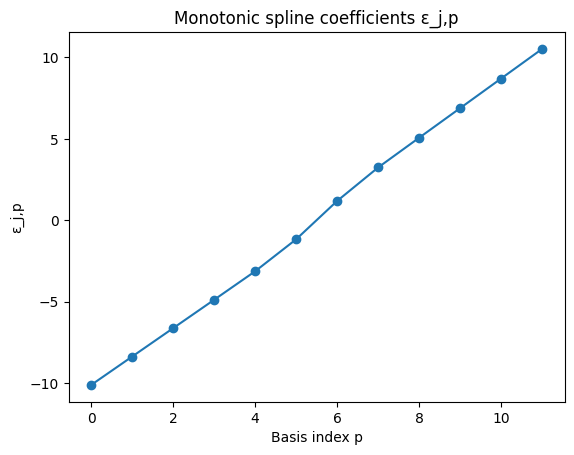

BAY
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.8391, -8.1847, -6.2716, -4.4456, -2.6442, -0.8672,  0.9003,  2.6631,
         4.4210,  6.1769,  7.9295,  9.6763])


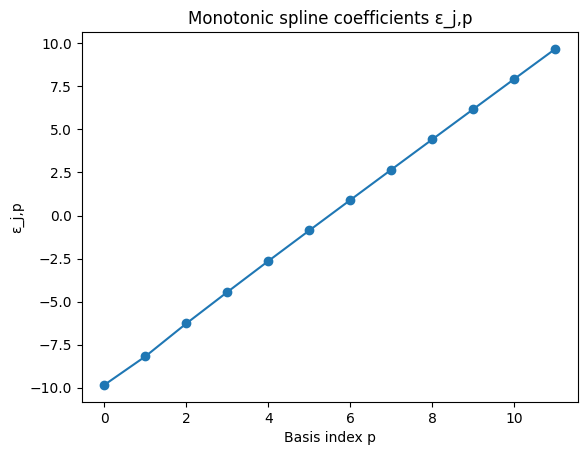

FREQ
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.0978,  -8.3476,  -6.5974,  -4.8473,  -3.0946,  -1.1551,   1.1378,
          3.1238,   4.9529,   6.7711,   8.5893,  10.4074])


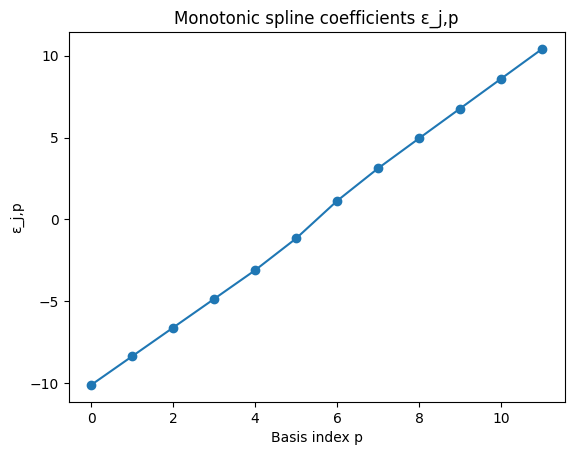

BAY
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.8372, -8.1824, -6.2665, -4.4405, -2.6481, -0.8759,  0.8944,  2.6530,
         4.4060,  6.1585,  7.9075,  9.6503])


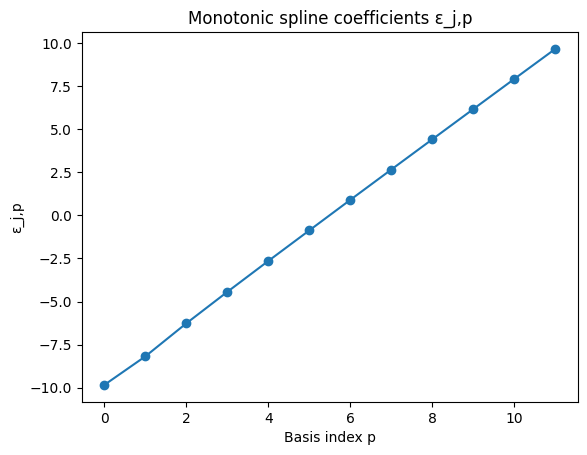

In [9]:
print("FREQ")
sanity_check(model_freq, transformation_grad=0)
print("BAY")
sanity_check(model, transformation_grad=0)
print("FREQ")
sanity_check(model_freq, transformation_grad=1)
print("BAY")
sanity_check(model, transformation_grad=1)

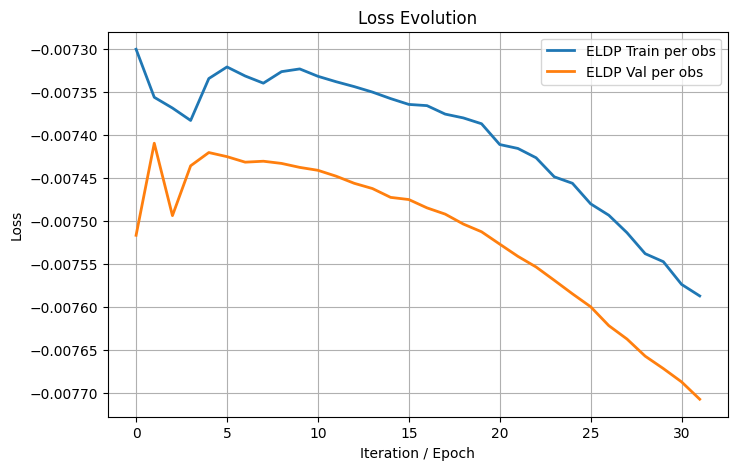

In [10]:
elbo= output['loss_history']
loss_history = output['ll_history']
val_loss = output['val_history']
mean_log_q = output['mean_log_q']
mean_log_p_tilde = output['mean_log_p_tilde']


# Plot            
plt.figure(figsize=(8, 5))
#plt.plot(mean_log_q, label= "mean_log_q per obs")
#plt.plot(mean_log_p_tilde, label= "mean_log_p_tilde per obs")
#plt.plot(elbo, label= "ELBO per obs")
plt.plot(loss_history, label="ELDP Train per obs", linewidth=2)
plt.plot(val_loss, label="ELDP Val per obs", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
print(
    "freq_model nr. parameters", sum(p.numel() for p in model_freq.parameters() if p.requires_grad),
    "bay_model nr. parameters", sum(p.numel() for p in model.parameters() if p.requires_grad))

print("VI Model params = ",output['mu'])
print("BGTM params = ",[p for p in model.parameters() if p.requires_grad])
print("GTMp params = ",[p for p in model_freq.parameters() if p.requires_grad])

freq_model nr. parameters 24 bay_model nr. parameters 24
VI Model params =  tensor([-9.8391,  1.4421,  1.7534,  1.6504,  1.6210,  1.5916,  1.5803,  1.5746,
         1.5686,  1.5663,  1.5623,  1.5552, -9.8372,  1.4427,  1.7566,  1.6504,
         1.6102,  1.5859,  1.5836,  1.5696,  1.5627,  1.5621,  1.5579,  1.5505],
       device='cuda:0')
BGTM params =  [Parameter containing:
tensor([-9.8391,  1.4421,  1.7534,  1.6504,  1.6210,  1.5916,  1.5803,  1.5746,
         1.5686,  1.5663,  1.5623,  1.5552], device='cuda:0',
       requires_grad=True), Parameter containing:
tensor([-9.8372,  1.4427,  1.7566,  1.6504,  1.6102,  1.5859,  1.5836,  1.5696,
         1.5627,  1.5621,  1.5579,  1.5505], device='cuda:0',
       requires_grad=True)]
GTMp params =  [Parameter containing:
tensor([-10.1069,   1.5511,   1.5511,   1.5511,   1.5598,   1.8119,   2.2538,
          1.9193,   1.6490,   1.6411,   1.6411,   1.6411], requires_grad=True), Parameter containing:
tensor([-10.0978,   1.5593,   1.5593,   1

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [12]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [13]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [14]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0972
KLD GTM      Train Data:  0.0028
KLD Gaussian Train Data:  -0.0013
KLD Copula   Train Data:  -0.0001

KLD BGTM      Test  Data:  0.0873
KLD GTM      Test  Data:  0.0023
KLD Gaussian Test  Data:  0.0012
KLD Copula   Test  Data:  0.0045


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [15]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

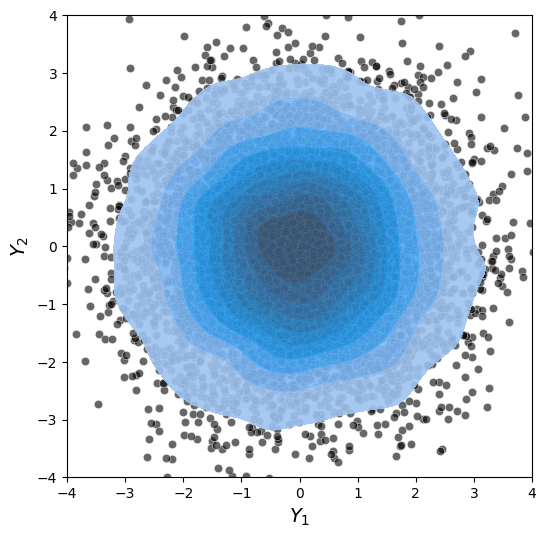

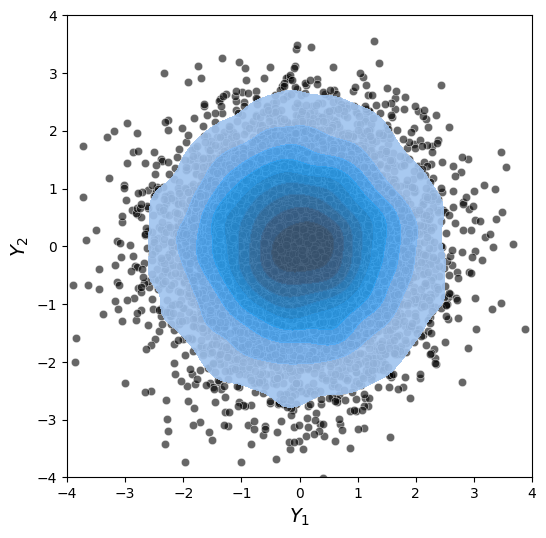

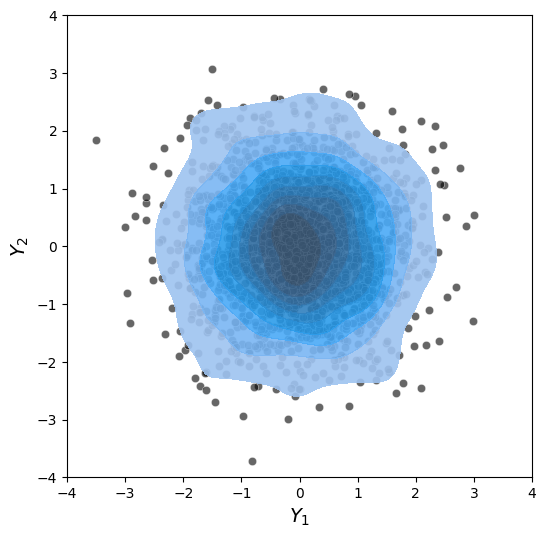

In [16]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

# Test 2
Independence copula + shifted/scaled Gaussian marginals (N(μ, σ²))

In [17]:
# User-chosen marginal parameters
mu = torch.tensor([1.5, -0.7], dtype=torch.float32)
sigma = torch.tensor([1.8, 0.6], dtype=torch.float32)  # stds

# ---------- Copula ----------
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)

# ---------- Train ----------
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
# Transform uniforms to shifted/scaled Gaussians
Z_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()
simulated_data_train = mu + sigma * Z_train

# ---------- Validate ----------
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
Z_val = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()
simulated_data_validate = mu + sigma * Z_val

# ---------- Test ----------
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
Z_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()
simulated_data_test = mu + sigma * Z_test

# ---------- "True" log-likelihoods under independence + N(mu, sigma^2) ----------
loglik_true_train = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_train).sum(1)
loglik_true_validate = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_validate).sum(1)
loglik_true_test = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_test).sum(1)

# ---------- "Estimated" marginals from train (fit μ, σ from train) ----------
means = simulated_data_train.mean(0)
stds  = simulated_data_train.std(0, unbiased=True)

loglik_true_est_train = torch.distributions.Normal(means, stds).log_prob(simulated_data_train).sum(1)
loglik_true_est_validate = torch.distributions.Normal(means, stds).log_prob(simulated_data_validate).sum(1)
loglik_true_est_test = torch.distributions.Normal(means, stds).log_prob(simulated_data_test).sum(1)

# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=300)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=300)

### BGTM model

In [18]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True

output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.00001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.5,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=12, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 3,
                warm_sigma_epochs = 10,  # try 5–10
                #Optimization method
                beta_kl_start= 1.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 15,  # how fast to decay to 1.0
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=2000  current B=300  (training objective uses scaled likelihood & unscaled prior)


  0%|          | 1/200 [00:04<14:07,  4.26s/it]

IMPROVED! Congrats
[1/200] ELBO train=717.2945  val_ELPD=-0.0076  train_ELPD=-0.0077  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈717  tau4=0.600815  rank=20  E_qf_mean≈18.5  E_qf_total≈36.9  tau*E_qf≈22.2  target≈22.2  resid≈-2.05e+05    tau4_mean=0.601   Elog_tau=-0.555    â=11.1     b̂=18.5  Δ=-1.11e+04      KL(qτ||pτ)≈0.00411     β_KL=1.50  


  1%|          | 2/200 [00:06<10:18,  3.12s/it]

IMPROVED! Congrats
[2/200] ELBO train=0.3331  val_ELPD=-0.0069  train_ELPD=-0.0075  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0836  tau4=0.618014  rank=20  E_qf_mean≈18  E_qf_total≈35.9  tau*E_qf≈22.2  target≈22.2  resid≈0.309    tau4_mean=0.618   Elog_tau=-0.527    â=11.1     b̂=18  Δ=+1.72e-02      KL(qτ||pτ)≈0.00396     β_KL=1.47  


  2%|▏         | 3/200 [00:07<07:35,  2.31s/it]

IMPROVED! Congrats
[3/200] ELBO train=0.3297  val_ELPD=-0.0062  train_ELPD=-0.0068  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0828  tau4=0.628108  rank=20  E_qf_mean≈17.7  E_qf_total≈35.3  tau*E_qf≈22.2  target≈22.2  resid≈0.178    tau4_mean=0.628   Elog_tau=-0.511    â=11.1     b̂=17.7  Δ=+1.01e-02      KL(qτ||pτ)≈0.00395     β_KL=1.43  


  2%|▏         | 4/200 [00:09<06:18,  1.93s/it]

IMPROVED! Congrats
[4/200] ELBO train=0.3195  val_ELPD=-0.0058  train_ELPD=-0.0062  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0812  tau4=0.63512  rank=20  E_qf_mean≈17.5  E_qf_total≈35  tau*E_qf≈22.2  target≈22.2  resid≈0.123    tau4_mean=0.635   Elog_tau=-0.5    â=11.1     b̂=17.5  Δ=+7.01e-03      KL(qτ||pτ)≈0.00394     β_KL=1.40  


  2%|▎         | 5/200 [00:10<05:35,  1.72s/it]

IMPROVED! Congrats
[5/200] ELBO train=0.3005  val_ELPD=-0.0057  train_ELPD=-0.0059  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0789  tau4=0.642689  rank=20  E_qf_mean≈17.3  E_qf_total≈34.5  tau*E_qf≈22.2  target≈22.2  resid≈0.131    tau4_mean=0.643   Elog_tau=-0.488    â=11.1     b̂=17.3  Δ=+7.57e-03      KL(qτ||pτ)≈0.00393     β_KL=1.37  


  3%|▎         | 6/200 [00:11<05:09,  1.59s/it]

NOT IMPROVED! Nr. 1
[6/200] ELBO train=0.2985  val_ELPD=-0.0057  train_ELPD=-0.0058  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0764  tau4=0.65362  rank=20  E_qf_mean≈17  E_qf_total≈34  tau*E_qf≈22.2  target≈22.2  resid≈0.186    tau4_mean=0.654   Elog_tau=-0.471    â=11.1     b̂=17  Δ=+1.09e-02      KL(qτ||pτ)≈0.00393     β_KL=1.33  


  4%|▎         | 7/200 [00:13<04:51,  1.51s/it]

IMPROVED! Congrats
[7/200] ELBO train=0.2959  val_ELPD=-0.0056  train_ELPD=-0.0058  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0742  tau4=0.668408  rank=20  E_qf_mean≈16.6  E_qf_total≈33.2  tau*E_qf≈22.2  target≈22.2  resid≈0.246    tau4_mean=0.668   Elog_tau=-0.449    â=11.1     b̂=16.6  Δ=+1.48e-02      KL(qτ||pτ)≈0.00392     β_KL=1.30  


  4%|▍         | 8/200 [00:14<04:39,  1.46s/it]

IMPROVED! Congrats
[8/200] ELBO train=0.2821  val_ELPD=-0.0056  train_ELPD=-0.0057  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0723  tau4=0.686181  rank=20  E_qf_mean≈16.2  E_qf_total≈32.4  tau*E_qf≈22.2  target≈22.2  resid≈0.288    tau4_mean=0.686   Elog_tau=-0.422    â=11.1     b̂=16.2  Δ=+1.78e-02      KL(qτ||pτ)≈0.00391     β_KL=1.27  


  4%|▍         | 9/200 [00:16<04:31,  1.42s/it]

IMPROVED! Congrats
[9/200] ELBO train=0.2846  val_ELPD=-0.0055  train_ELPD=-0.0056  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0705  tau4=0.705914  rank=20  E_qf_mean≈15.7  E_qf_total≈31.4  tau*E_qf≈22.2  target≈22.2  resid≈0.31    tau4_mean=0.706   Elog_tau=-0.394    â=11.1     b̂=15.7  Δ=+1.97e-02      KL(qτ||pτ)≈0.00389     β_KL=1.23  


  5%|▌         | 10/200 [00:17<04:25,  1.40s/it]

IMPROVED! Congrats
[10/200] ELBO train=0.2763  val_ELPD=-0.0055  train_ELPD=-0.0056  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0687  tau4=0.726681  rank=20  E_qf_mean≈15.3  E_qf_total≈30.5  tau*E_qf≈22.2  target≈22.2  resid≈0.317    tau4_mean=0.727   Elog_tau=-0.365    â=11.1     b̂=15.3  Δ=+2.08e-02      KL(qτ||pτ)≈0.00388     β_KL=1.20  


  6%|▌         | 11/200 [00:18<04:21,  1.38s/it]

IMPROVED! Congrats
[11/200] ELBO train=0.2555  val_ELPD=-0.0054  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0517 σmin=0.0517 σmax=0.0517  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0669  tau4=0.747951  rank=20  E_qf_mean≈14.8  E_qf_total≈29.7  tau*E_qf≈22.2  target≈22.2  resid≈0.316    tau4_mean=0.748   Elog_tau=-0.336    â=11.1     b̂=14.8  Δ=+2.13e-02      KL(qτ||pτ)≈0.00386     β_KL=1.17  


  6%|▌         | 12/200 [00:20<04:17,  1.37s/it]

IMPROVED! Congrats
[12/200] ELBO train=0.2535  val_ELPD=-0.0054  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0535 σmin=0.0535 σmax=0.0535  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0652  tau4=0.768502  rank=20  E_qf_mean≈14.4  E_qf_total≈28.9  tau*E_qf≈22.2  target≈22.2  resid≈0.297    tau4_mean=0.769   Elog_tau=-0.309    â=11.1     b̂=14.4  Δ=+2.06e-02      KL(qτ||pτ)≈0.00384     β_KL=1.13  


  6%|▋         | 13/200 [00:21<04:15,  1.36s/it]

IMPROVED! Congrats
[13/200] ELBO train=0.2442  val_ELPD=-0.0054  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0554 σmin=0.0554 σmax=0.0554  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0635  tau4=0.788765  rank=20  E_qf_mean≈14.1  E_qf_total≈28.1  tau*E_qf≈22.2  target≈22.2  resid≈0.285    tau4_mean=0.789   Elog_tau=-0.283    â=11.1     b̂=14.1  Δ=+2.03e-02      KL(qτ||pτ)≈0.00383     β_KL=1.10  


  7%|▋         | 14/200 [00:22<04:12,  1.36s/it]

NOT IMPROVED! Nr. 1
[14/200] ELBO train=0.2345  val_ELPD=-0.0054  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0573 σmin=0.0573 σmax=0.0573  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0617  tau4=0.809701  rank=20  E_qf_mean≈13.7  E_qf_total≈27.4  tau*E_qf≈22.2  target≈22.2  resid≈0.287    tau4_mean=0.81   Elog_tau=-0.257    â=11.1     b̂=13.7  Δ=+2.09e-02      KL(qτ||pτ)≈0.00382     β_KL=1.07  


  8%|▊         | 15/200 [00:24<04:10,  1.36s/it]

IMPROVED! Congrats
[15/200] ELBO train=0.2308  val_ELPD=-0.0054  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0592 σmin=0.0592 σmax=0.0592  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0598  tau4=0.832189  rank=20  E_qf_mean≈13.3  E_qf_total≈26.7  tau*E_qf≈22.2  target≈22.2  resid≈0.3    tau4_mean=0.832   Elog_tau=-0.229    â=11.1     b̂=13.3  Δ=+2.25e-02      KL(qτ||pτ)≈0.0038     β_KL=1.03  


  8%|▊         | 16/200 [00:25<04:09,  1.35s/it]

NOT IMPROVED! Nr. 1
[16/200] ELBO train=0.2155  val_ELPD=-0.0054  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0612 σmin=0.0612 σmax=0.0612  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0578  tau4=0.856105  rank=20  E_qf_mean≈13  E_qf_total≈25.9  tau*E_qf≈22.2  target≈22.2  resid≈0.31    tau4_mean=0.856   Elog_tau=-0.201    â=11.1     b̂=13  Δ=+2.39e-02      KL(qτ||pτ)≈0.00379     β_KL=1.00  


  8%|▊         | 17/200 [00:26<04:07,  1.35s/it]

NOT IMPROVED! Nr. 2
[17/200] ELBO train=0.2117  val_ELPD=-0.0054  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0633 σmin=0.0632 σmax=0.0633  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0558  tau4=0.882003  rank=20  E_qf_mean≈12.6  E_qf_total≈25.2  tau*E_qf≈22.2  target≈22.2  resid≈0.326    tau4_mean=0.882   Elog_tau=-0.171    â=11.1     b̂=12.6  Δ=+2.59e-02      KL(qτ||pτ)≈0.00377     β_KL=1.00  


  9%|▉         | 18/200 [00:28<04:05,  1.35s/it]

NOT IMPROVED! Nr. 3
[18/200] ELBO train=0.2092  val_ELPD=-0.0054  train_ELPD=-0.0054  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0654 σmin=0.0653 σmax=0.0654  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0537  tau4=0.909669  rank=20  E_qf_mean≈12.2  E_qf_total≈24.4  tau*E_qf≈22.2  target≈22.2  resid≈0.338    tau4_mean=0.91   Elog_tau=-0.14    â=11.1     b̂=12.2  Δ=+2.77e-02      KL(qτ||pτ)≈0.00375     β_KL=1.00  


 10%|▉         | 19/200 [00:29<04:04,  1.35s/it]

NOT IMPROVED! Nr. 4
[19/200] ELBO train=0.2018  val_ELPD=-0.0054  train_ELPD=-0.0054  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0675 σmin=0.0675 σmax=0.0676  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0515  tau4=0.938922  rank=20  E_qf_mean≈11.8  E_qf_total≈23.6  tau*E_qf≈22.2  target≈22.2  resid≈0.346    tau4_mean=0.939   Elog_tau=-0.109    â=11.1     b̂=11.8  Δ=+2.93e-02      KL(qτ||pτ)≈0.00374     β_KL=1.00  


 10%|█         | 20/200 [00:30<04:02,  1.35s/it]

NOT IMPROVED! Nr. 5
[20/200] ELBO train=0.1948  val_ELPD=-0.0054  train_ELPD=-0.0054  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0698 σmin=0.0697 σmax=0.0698  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0493  tau4=0.969596  rank=20  E_qf_mean≈11.4  E_qf_total≈22.9  tau*E_qf≈22.2  target≈22.2  resid≈0.351    tau4_mean=0.97   Elog_tau=-0.0766    â=11.1     b̂=11.4  Δ=+3.07e-02      KL(qτ||pτ)≈0.00372     β_KL=1.00  


 10%|█         | 21/200 [00:32<04:01,  1.35s/it]

NOT IMPROVED! Nr. 6
[21/200] ELBO train=0.1943  val_ELPD=-0.0054  train_ELPD=-0.0054  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0721 σmin=0.0720 σmax=0.0721  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.047  tau4=1.00269  rank=20  E_qf_mean≈11.1  E_qf_total≈22.1  tau*E_qf≈22.2  target≈22.2  resid≈0.366    tau4_mean=1   Elog_tau=-0.043    â=11.1     b̂=11.1  Δ=+3.31e-02      KL(qτ||pτ)≈0.0037     β_KL=1.00  


 11%|█         | 22/200 [00:33<04:00,  1.35s/it]

NOT IMPROVED! Nr. 7
[22/200] ELBO train=0.1866  val_ELPD=-0.0054  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0744 σmin=0.0743 σmax=0.0745  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0447  tau4=1.0375  rank=20  E_qf_mean≈10.7  E_qf_total≈21.4  tau*E_qf≈22.2  target≈22.2  resid≈0.372    tau4_mean=1.04   Elog_tau=-0.00891    â=11.1     b̂=10.7  Δ=+3.48e-02      KL(qτ||pτ)≈0.00368     β_KL=1.00  


 12%|█▏        | 23/200 [00:34<03:58,  1.35s/it]

NOT IMPROVED! Nr. 8
[23/200] ELBO train=0.1853  val_ELPD=-0.0054  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0768 σmin=0.0767 σmax=0.0769  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0424  tau4=1.07455  rank=20  E_qf_mean≈10.3  E_qf_total≈20.7  tau*E_qf≈22.2  target≈22.2  resid≈0.383    tau4_mean=1.07   Elog_tau=0.0262    â=11.1     b̂=10.3  Δ=+3.70e-02      KL(qτ||pτ)≈0.00366     β_KL=1.00  


 12%|█▏        | 24/200 [00:36<03:57,  1.35s/it]

NOT IMPROVED! Nr. 9
[24/200] ELBO train=0.1813  val_ELPD=-0.0054  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0793 σmin=0.0792 σmax=0.0794  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.04  tau4=1.1139  rank=20  E_qf_mean≈9.96  E_qf_total≈19.9  tau*E_qf≈22.2  target≈22.2  resid≈0.392    tau4_mean=1.11   Elog_tau=0.0621    â=11.1     b̂=9.96  Δ=+3.94e-02      KL(qτ||pτ)≈0.00365     β_KL=1.00  


 12%|█▎        | 25/200 [00:37<03:56,  1.35s/it]

NOT IMPROVED! Nr. 10
[25/200] ELBO train=0.1732  val_ELPD=-0.0054  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0819 σmin=0.0818 σmax=0.0820  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0375  tau4=1.15488  rank=20  E_qf_mean≈9.61  E_qf_total≈19.2  tau*E_qf≈22.2  target≈22.2  resid≈0.394    tau4_mean=1.15   Elog_tau=0.0983    â=11.1     b̂=9.61  Δ=+4.10e-02      KL(qτ||pτ)≈0.00363     β_KL=1.00  


 13%|█▎        | 26/200 [00:38<03:54,  1.35s/it]

NOT IMPROVED! Nr. 11
[26/200] ELBO train=0.1663  val_ELPD=-0.0055  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0845 σmin=0.0844 σmax=0.0846  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.035  tau4=1.19915  rank=20  E_qf_mean≈9.26  E_qf_total≈18.5  tau*E_qf≈22.2  target≈22.2  resid≈0.41    tau4_mean=1.2   Elog_tau=0.136    â=11.1     b̂=9.26  Δ=+4.43e-02      KL(qτ||pτ)≈0.00361     β_KL=1.00  


 14%|█▎        | 27/200 [00:40<03:53,  1.35s/it]

NOT IMPROVED! Nr. 12
[27/200] ELBO train=0.1665  val_ELPD=-0.0055  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0872 σmin=0.0871 σmax=0.0873  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0325  tau4=1.24684  rank=20  E_qf_mean≈8.9  E_qf_total≈17.8  tau*E_qf≈22.2  target≈22.2  resid≈0.425    tau4_mean=1.25   Elog_tau=0.175    â=11.1     b̂=8.9  Δ=+4.77e-02      KL(qτ||pτ)≈0.00358     β_KL=1.00  


 14%|█▍        | 28/200 [00:41<03:51,  1.35s/it]

NOT IMPROVED! Nr. 13
[28/200] ELBO train=0.1599  val_ELPD=-0.0055  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0900 σmin=0.0898 σmax=0.0901  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.03  tau4=1.29623  rank=20  E_qf_mean≈8.56  E_qf_total≈17.1  tau*E_qf≈22.2  target≈22.2  resid≈0.423    tau4_mean=1.3   Elog_tau=0.214    â=11.1     b̂=8.56  Δ=+4.94e-02      KL(qτ||pτ)≈0.00356     β_KL=1.00  


 14%|█▍        | 29/200 [00:42<03:50,  1.35s/it]

NOT IMPROVED! Nr. 14
[29/200] ELBO train=0.1581  val_ELPD=-0.0055  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0929 σmin=0.0927 σmax=0.0930  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0273  tau4=1.35104  rank=20  E_qf_mean≈8.21  E_qf_total≈16.4  tau*E_qf≈22.2  target≈22.2  resid≈0.45    tau4_mean=1.35   Elog_tau=0.255    â=11.1     b̂=8.22  Δ=+5.48e-02      KL(qτ||pτ)≈0.00354     β_KL=1.00  


 15%|█▌        | 30/200 [00:44<03:49,  1.35s/it]

NOT IMPROVED! Nr. 15
[30/200] ELBO train=0.1513  val_ELPD=-0.0055  train_ELPD=-0.0056  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0949 σmin=0.0947 σmax=0.0950  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0253  tau4=1.39999  rank=20  E_qf_mean≈7.93  E_qf_total≈15.9  tau*E_qf≈22.2  target≈22.2  resid≈0.388    tau4_mean=1.4   Elog_tau=0.291    â=11.1     b̂=7.93  Δ=+4.90e-02      KL(qτ||pτ)≈0.00352     β_KL=1.00  


 16%|█▌        | 31/200 [00:45<03:47,  1.35s/it]

NOT IMPROVED! Nr. 16
[31/200] ELBO train=0.1470  val_ELPD=-0.0055  train_ELPD=-0.0056  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0970 σmin=0.0967 σmax=0.0971  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0237  tau4=1.44318  rank=20  E_qf_mean≈7.69  E_qf_total≈15.4  tau*E_qf≈22.2  target≈22.2  resid≈0.332    tau4_mean=1.44   Elog_tau=0.321    â=11.1     b̂=7.69  Δ=+4.32e-02      KL(qτ||pτ)≈0.0035     β_KL=1.00  


 16%|█▌        | 32/200 [00:47<03:46,  1.35s/it]

NOT IMPROVED! Nr. 17
[32/200] ELBO train=0.1411  val_ELPD=-0.0055  train_ELPD=-0.0056  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0991 σmin=0.0988 σmax=0.0992  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0219  tau4=1.48815  rank=20  E_qf_mean≈7.46  E_qf_total≈14.9  tau*E_qf≈22.2  target≈22.2  resid≈0.335    tau4_mean=1.49   Elog_tau=0.352    â=11.1     b̂=7.46  Δ=+4.50e-02      KL(qτ||pτ)≈0.00348     β_KL=1.00  


 16%|█▋        | 33/200 [00:48<03:45,  1.35s/it]

NOT IMPROVED! Nr. 18
[33/200] ELBO train=0.1428  val_ELPD=-0.0056  train_ELPD=-0.0056  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1012 σmin=0.1010 σmax=0.1014  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0201  tau4=1.53629  rank=20  E_qf_mean≈7.22  E_qf_total≈14.4  tau*E_qf≈22.2  target≈22.2  resid≈0.348    tau4_mean=1.54   Elog_tau=0.384    â=11.1     b̂=7.23  Δ=+4.81e-02      KL(qτ||pτ)≈0.00347     β_KL=1.00  


 17%|█▋        | 34/200 [00:49<03:43,  1.35s/it]

NOT IMPROVED! Nr. 19
[34/200] ELBO train=0.1369  val_ELPD=-0.0056  train_ELPD=-0.0056  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1034 σmin=0.1031 σmax=0.1036  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0183  tau4=1.58543  rank=20  E_qf_mean≈7  E_qf_total≈14  tau*E_qf≈22.2  target≈22.2  resid≈0.344    tau4_mean=1.59   Elog_tau=0.415    â=11.1     b̂=7  Δ=+4.91e-02      KL(qτ||pτ)≈0.00345     β_KL=1.00  


 18%|█▊        | 35/200 [00:51<03:42,  1.35s/it]

NOT IMPROVED! Nr. 20
[35/200] ELBO train=0.1305  val_ELPD=-0.0056  train_ELPD=-0.0057  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1057 σmin=0.1054 σmax=0.1059  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0164  tau4=1.63809  rank=20  E_qf_mean≈6.78  E_qf_total≈13.6  tau*E_qf≈22.2  target≈22.2  resid≈0.357    tau4_mean=1.64   Elog_tau=0.448    â=11.1     b̂=6.78  Δ=+5.27e-02      KL(qτ||pτ)≈0.00343     β_KL=1.00  


 18%|█▊        | 36/200 [00:52<03:41,  1.35s/it]

NOT IMPROVED! Nr. 21
[36/200] ELBO train=0.1204  val_ELPD=-0.0057  train_ELPD=-0.0057  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1079 σmin=0.1075 σmax=0.1082  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0145  tau4=1.69416  rank=20  E_qf_mean≈6.55  E_qf_total≈13.1  tau*E_qf≈22.2  target≈22.2  resid≈0.367    tau4_mean=1.69   Elog_tau=0.481    â=11.1     b̂=6.55  Δ=+5.61e-02      KL(qτ||pτ)≈0.00341     β_KL=1.00  


 18%|█▊        | 37/200 [00:53<03:39,  1.35s/it]

NOT IMPROVED! Nr. 22
[37/200] ELBO train=0.1227  val_ELPD=-0.0057  train_ELPD=-0.0057  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1102 σmin=0.1098 σmax=0.1105  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0126  tau4=1.75659  rank=20  E_qf_mean≈6.32  E_qf_total≈12.6  tau*E_qf≈22.2  target≈22.2  resid≈0.394    tau4_mean=1.76   Elog_tau=0.518    â=11.1     b̂=6.32  Δ=+6.24e-02      KL(qτ||pτ)≈0.0034     β_KL=1.00  


 19%|█▉        | 38/200 [00:55<03:38,  1.35s/it]

NOT IMPROVED! Nr. 23
[38/200] ELBO train=0.1233  val_ELPD=-0.0057  train_ELPD=-0.0057  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1126 σmin=0.1121 σmax=0.1129  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0108  tau4=1.82195  rank=20  E_qf_mean≈6.09  E_qf_total≈12.2  tau*E_qf≈22.2  target≈22.2  resid≈0.398    tau4_mean=1.82   Elog_tau=0.554    â=11.1     b̂=6.09  Δ=+6.54e-02      KL(qτ||pτ)≈0.00338     β_KL=1.00  


 20%|█▉        | 39/200 [00:56<03:37,  1.35s/it]

NOT IMPROVED! Nr. 24
[39/200] ELBO train=0.1152  val_ELPD=-0.0057  train_ELPD=-0.0058  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1150 σmin=0.1145 σmax=0.1153  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.00894  tau4=1.89158  rank=20  E_qf_mean≈5.87  E_qf_total≈11.7  tau*E_qf≈22.2  target≈22.2  resid≈0.409    tau4_mean=1.89   Elog_tau=0.592    â=11.1     b̂=5.87  Δ=+6.96e-02      KL(qτ||pτ)≈0.00336     β_KL=1.00  


 20%|██        | 40/200 [00:57<03:36,  1.35s/it]

NOT IMPROVED! Nr. 25
[40/200] ELBO train=0.1139  val_ELPD=-0.0057  train_ELPD=-0.0057  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1174 σmin=0.1169 σmax=0.1178  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.00714  tau4=1.96256  rank=20  E_qf_mean≈5.65  E_qf_total≈11.3  tau*E_qf≈22.2  target≈22.2  resid≈0.401    tau4_mean=1.96   Elog_tau=0.629    â=11.1     b̂=5.66  Δ=+7.10e-02      KL(qτ||pτ)≈0.00333     β_KL=1.00  


 20%|██        | 41/200 [00:59<03:34,  1.35s/it]

NOT IMPROVED! Nr. 26
[41/200] ELBO train=0.1123  val_ELPD=-0.0058  train_ELPD=-0.0058  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1199 σmin=0.1193 σmax=0.1203  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.00517  tau4=2.04427  rank=20  E_qf_mean≈5.43  E_qf_total≈10.9  tau*E_qf≈22.2  target≈22.2  resid≈0.444    tau4_mean=2.04   Elog_tau=0.669    â=11.1     b̂=5.43  Δ=+8.17e-02      KL(qτ||pτ)≈0.00331     β_KL=1.00  


 21%|██        | 42/200 [01:00<03:33,  1.35s/it]

NOT IMPROVED! Nr. 27
[42/200] ELBO train=0.1032  val_ELPD=-0.0058  train_ELPD=-0.0058  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1224 σmin=0.1218 σmax=0.1229  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.0035  tau4=2.11992  rank=20  E_qf_mean≈5.24  E_qf_total≈10.5  tau*E_qf≈22.2  target≈22.2  resid≈0.396    tau4_mean=2.12   Elog_tau=0.706    â=11.1     b̂=5.24  Δ=+7.57e-02      KL(qτ||pτ)≈0.00329     β_KL=1.00  


 22%|██▏       | 43/200 [01:01<03:31,  1.35s/it]

NOT IMPROVED! Nr. 28
[43/200] ELBO train=0.0972  val_ELPD=-0.0058  train_ELPD=-0.0059  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1250 σmin=0.1243 σmax=0.1255  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈0.00143  tau4=2.21198  rank=20  E_qf_mean≈5.02  E_qf_total≈10  tau*E_qf≈22.2  target≈22.2  resid≈0.462    tau4_mean=2.21   Elog_tau=0.748    â=11.1     b̂=5.02  Δ=+9.21e-02      KL(qτ||pτ)≈0.00327     β_KL=1.00  


 22%|██▏       | 44/200 [01:03<03:30,  1.35s/it]

NOT IMPROVED! Nr. 29
[44/200] ELBO train=0.1017  val_ELPD=-0.0059  train_ELPD=-0.0059  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1268 σmin=0.1261 σmax=0.1273  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈1.81e-05  tau4=2.29595  rank=20  E_qf_mean≈4.83  E_qf_total≈9.67  tau*E_qf≈22.2  target≈22.2  resid≈0.406    tau4_mean=2.3   Elog_tau=0.785    â=11.1     b̂=4.83  Δ=+8.40e-02      KL(qτ||pτ)≈0.00325     β_KL=1.00  


 22%|██▏       | 44/200 [01:04<03:48,  1.47s/it]

NOT IMPROVED! Nr. 30
[45/200] ELBO train=0.1004  val_ELPD=-0.0059  train_ELPD=-0.0059  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1287 σmin=0.1278 σmax=0.1292  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-0.000988  tau4=2.36442  rank=20  E_qf_mean≈4.69  E_qf_total≈9.39  tau*E_qf≈22.2  target≈22.2  resid≈0.321    tau4_mean=2.36   Elog_tau=0.815    â=11.1     b̂=4.69  Δ=+6.85e-02      KL(qτ||pτ)≈0.00323     β_KL=1.00  
Early stop @ epoch 45: no val improvement for 30 epochs.


### GTM model

In [19]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 1/1000 [00:00<02:26,  6.80it/s]

current_loss: tensor(2.2920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9168, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6375, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6070, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5110,

  0%|          | 2/1000 [00:00<02:18,  7.22it/s]

current_loss: tensor(1.4923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5071, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5068, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5186,

  0%|          | 4/1000 [00:00<02:28,  6.72it/s]

current_loss: tensor(1.4599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4984, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5168, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5159, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5135,

  0%|          | 5/1000 [00:00<02:35,  6.42it/s]

current_loss: tensor(1.4972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4965, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5128, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5076, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5070, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4967, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4984, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4961,

  1%|          | 6/1000 [00:00<02:29,  6.64it/s]

current_loss: tensor(1.4584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5072, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5072, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5068, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4967, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4706,

  1%|          | 8/1000 [00:01<02:23,  6.92it/s]

current_loss: tensor(1.5120, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5068, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5067, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4968, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4953, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5121, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5064, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5063,

  1%|          | 9/1000 [00:01<02:21,  7.02it/s]

current_loss: tensor(1.4568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5140, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5138, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4504, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5116, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5053, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4953, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4961, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4710,

  1%|          | 11/1000 [00:01<02:20,  7.04it/s]

current_loss: tensor(1.5117, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5114, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5057, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5113, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5135, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5132, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5117, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5113, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5054,

  1%|          | 12/1000 [00:01<02:19,  7.09it/s]

current_loss: tensor(1.4942, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5130, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5114, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5051, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5046, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4545,

  1%|▏         | 14/1000 [00:02<02:17,  7.18it/s]

current_loss: tensor(1.4484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5114, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5040, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5124, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5109,

  2%|▏         | 15/1000 [00:02<02:16,  7.20it/s]

current_loss: tensor(1.4937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5124, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4535,

  2%|▏         | 17/1000 [00:02<02:15,  7.23it/s]

current_loss: tensor(1.4473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5040, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4949, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5117, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4470, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5106,

  2%|▏         | 18/1000 [00:02<02:15,  7.23it/s]

current_loss: tensor(1.4933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5116, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4466, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4526,

  2%|▏         | 20/1000 [00:02<02:19,  7.00it/s]

current_loss: tensor(1.4464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4960, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5114, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5104,

  2%|▏         | 21/1000 [00:03<02:24,  6.76it/s]

current_loss: tensor(1.5033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4466, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5032, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5031, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5025, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4934,

  2%|▏         | 22/1000 [00:03<02:22,  6.88it/s]

current_loss: tensor(1.4675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5031, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5030, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4960, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4928, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5110,

  2%|▏         | 24/1000 [00:03<02:28,  6.59it/s]

current_loss: tensor(1.5029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5027, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5023,

  2%|▎         | 25/1000 [00:03<02:26,  6.66it/s]

current_loss: tensor(1.4977, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5027, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4926, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4514,

  3%|▎         | 27/1000 [00:03<02:22,  6.82it/s]

current_loss: tensor(1.5104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5025, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5025, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4934, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5073, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4926, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4444,

  3%|▎         | 28/1000 [00:04<02:21,  6.88it/s]

current_loss: tensor(1.5019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4977, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4443, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5016, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4937,

  3%|▎         | 30/1000 [00:04<02:18,  6.98it/s]

current_loss: tensor(1.4648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5016, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5100,

  3%|▎         | 31/1000 [00:04<02:17,  7.02it/s]

current_loss: tensor(1.5021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4949, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4504, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5014,

  3%|▎         | 32/1000 [00:04<02:18,  7.00it/s]

current_loss: tensor(1.4503, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4955, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4504, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4643,

  3%|▎         | 34/1000 [00:04<02:17,  7.05it/s]

current_loss: tensor(1.5103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5018, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5087, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4500, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5018,

  4%|▎         | 35/1000 [00:05<02:16,  7.05it/s]

current_loss: tensor(1.4923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5016, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5011, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4964, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4501, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4498,

  4%|▎         | 37/1000 [00:05<02:16,  7.03it/s]

current_loss: tensor(1.4439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5016, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5166, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4430, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5103,

  4%|▍         | 38/1000 [00:05<02:16,  7.04it/s]

current_loss: tensor(1.4927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4429, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4962, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4923,

  4%|▍         | 40/1000 [00:05<02:16,  7.02it/s]

current_loss: tensor(1.4651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4429, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4495, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5093,

  4%|▍         | 41/1000 [00:05<02:15,  7.05it/s]

current_loss: tensor(1.5013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5091, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4427, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4933,

  4%|▍         | 43/1000 [00:06<02:09,  7.42it/s]

current_loss: tensor(1.4646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5091, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4429, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5018, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433,

  4%|▍         | 44/1000 [00:06<02:10,  7.31it/s]

current_loss: tensor(1.5015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5011, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5006, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4933,

  5%|▍         | 46/1000 [00:06<02:11,  7.23it/s]

current_loss: tensor(1.4654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4928, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5089,

  5%|▍         | 47/1000 [00:06<02:11,  7.24it/s]

current_loss: tensor(1.5009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5006, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5087, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5004,

  5%|▍         | 48/1000 [00:06<02:11,  7.23it/s]

current_loss: tensor(1.4652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5087, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4429, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4421, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5004, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5032, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5089,

  5%|▍         | 48/1000 [00:06<02:18,  6.87it/s]

tensor(1.5097, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.0016,  -8.1887,  -6.3758,  -4.5652,  -2.8264,  -1.3875,  -0.1667,
          0.9345,   2.1914,   3.8977,   5.7176,   7.5358])


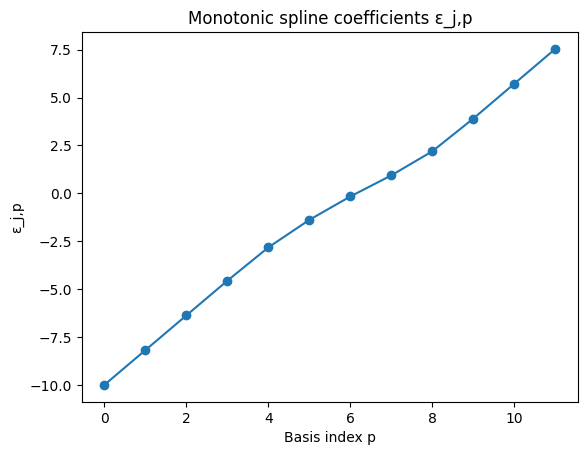

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.3638, -8.1884, -6.2368, -4.6451, -3.1219, -1.6609, -0.3229,  0.8892,
         1.9771,  2.9815,  3.9787,  4.9679])


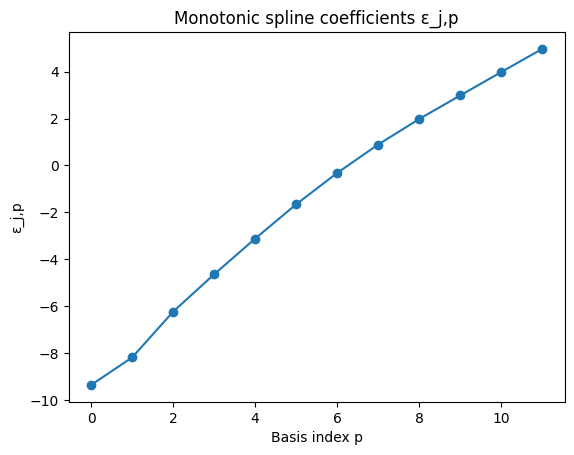

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.3125,  -8.7074,  -7.1024,  -5.4973,  -3.8706,  -0.8189,   3.1605,
          5.1127,   6.9310,   8.7492,  10.5673,  12.3855])


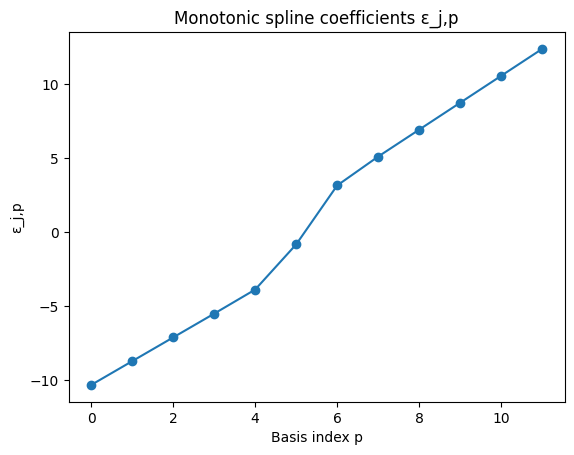

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.0863, -7.9843, -5.6856, -4.3146, -2.9844, -0.5588,  1.9856,  3.0186,
         3.9998,  4.9873,  5.9759,  6.9645])


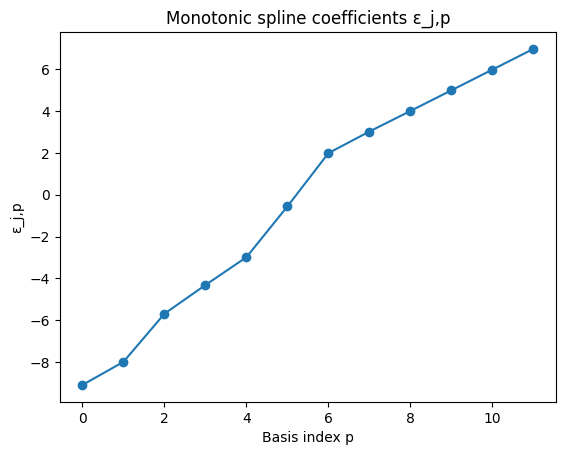

In [20]:
sanity_check(model_freq, transformation_grad=0)
sanity_check(model, transformation_grad=0)
sanity_check(model_freq, transformation_grad=1)
sanity_check(model, transformation_grad=1)

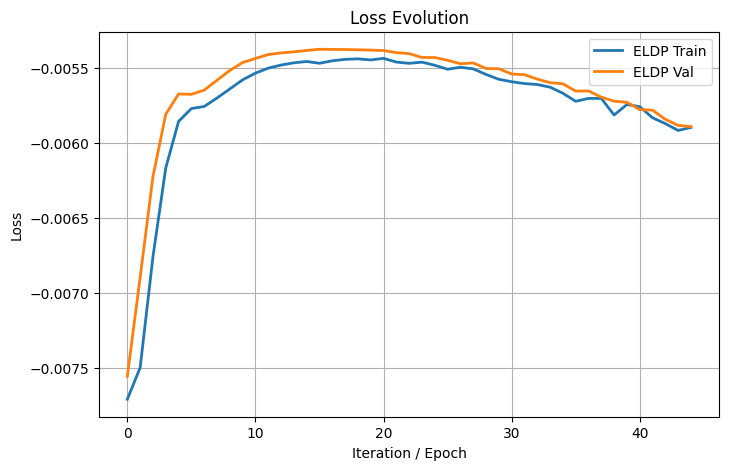

In [21]:
loss_history = output['ll_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="ELDP Train", linewidth=2)
plt.plot(val_loss, label="ELDP Val", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [23]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [24]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.1479
KLD GTM      Train Data:  0.0032
KLD Gaussian Train Data:  -0.0015
KLD Copula   Train Data:  -0.0012

KLD BGTM      Test  Data:  0.1592
KLD GTM      Test  Data:  0.0063
KLD Gaussian Test  Data:  0.0016
KLD Copula   Test  Data:  0.0013


In [25]:
#model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_model/gtm.py:1275: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn(


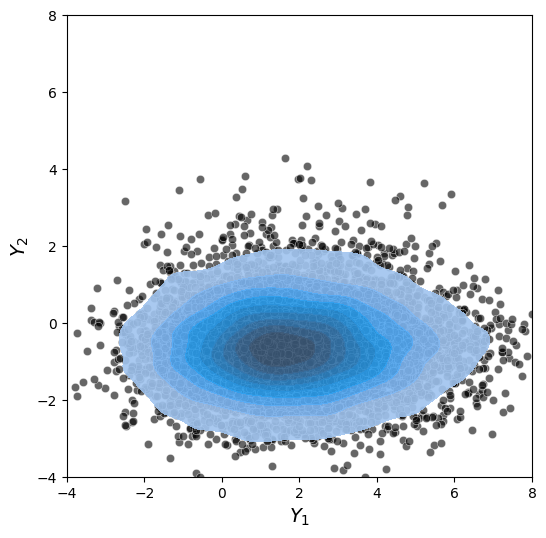

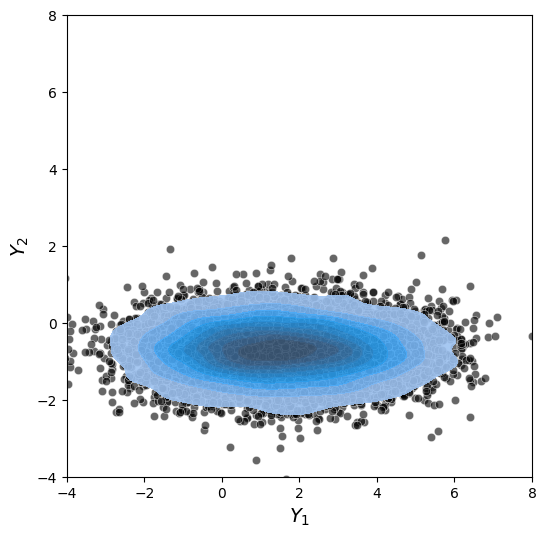

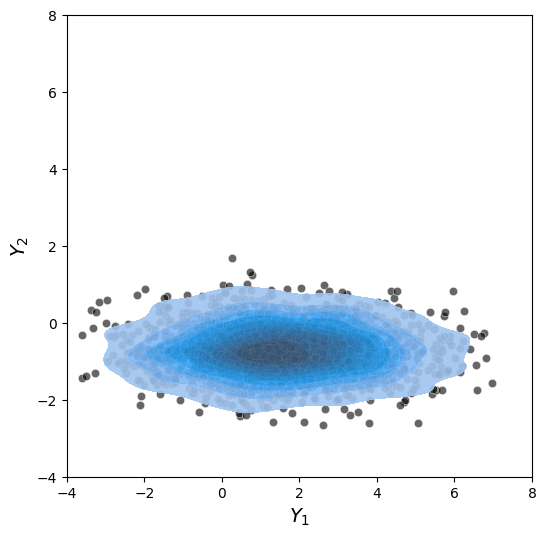

In [26]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,8], y_lim=[-4,8])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,8], y_lim=[-4,8])
model.plot_densities(simulated_data_train, x_lim=[-4,8], y_lim=[-4,8])

### Independence copula + two-component Gaussian mixture marginals (non-Gaussian)

In [37]:
import numpy as np
import torch
import pyvinecopulib as pv

# Mixture parameters per dimension (same weights across dims for simplicity)
w1 = 0.35  # w2 = 1 - w1
means = torch.tensor([[-2.0,  1.0],   # component 1 means per dim
                      [ 2.0, -1.0]],  # component 2 means per dim
                     dtype=torch.float32)
stds  = torch.tensor([[0.8, 0.5],
                      [0.6, 0.9]], dtype=torch.float32)

def gm2_icdf(u, w1, m, s):
    """
    u: [N, D] tensor in (0,1); w1 scalar; m,s: shape [2, D]
    Returns x: [N, D]
    """
    w2 = 1.0 - w1
    x = torch.empty_like(u)
    mask1 = (u < w1)
    u1 = torch.where(mask1, u / w1, torch.tensor(0.5, dtype=u.dtype))
    u2 = torch.where(~mask1, (u - w1) / w2, torch.tensor(0.5, dtype=u.dtype))
    # invert per dim
    for d in range(u.shape[1]):
        x1 = torch.distributions.Normal(m[0, d], s[0, d]).icdf(u1[:, d])
        x2 = torch.distributions.Normal(m[1, d], s[1, d]).icdf(u2[:, d])
        x[:, d] = torch.where(mask1[:, d], x1, x2)
    return x

def gm2_logpdf(x, w1, m, s):
    w2 = 1.0 - w1
    lp = torch.zeros(x.shape[0])
    for d in range(x.shape[1]):
        lp1 = torch.distributions.Normal(m[0, d], s[0, d]).log_prob(x[:, d])
        lp2 = torch.distributions.Normal(m[1, d], s[1, d]).log_prob(x[:, d])
        # log( w1*e^lp1 + w2*e^lp2 )
        a = torch.stack([lp1 + np.log(w1), lp2 + np.log(w2)], dim=1)
        lp += torch.logsumexp(a, dim=1)
    return lp

# ---------- Copula ----------
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)

# ---------- Train ----------
N_train = 20000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
U_train = torch.tensor(simulated_data_uniform_train).float()
simulated_data_train = gm2_icdf(U_train, w1, means, stds)

# ---------- Validate ----------
N_validate = 20000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
U_val = torch.tensor(simulated_data_uniform_validate).float()
simulated_data_validate = gm2_icdf(U_val, w1, means, stds)

# ---------- Test ----------
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
U_test = torch.tensor(simulated_data_uniform_test).float()
simulated_data_test = gm2_icdf(U_test, w1, means, stds)

# ---------- "True" log-likelihoods under independence + GM(2) marginals ----------
loglik_true_train = gm2_logpdf(simulated_data_train, w1, means, stds)
loglik_true_validate = gm2_logpdf(simulated_data_validate, w1, means, stds)
loglik_true_test = gm2_logpdf(simulated_data_test, w1, means, stds)

# ---------- (Optional) crude "estimated" marginals ----------
# For mixtures, proper estimation needs EM or VI. If you just want a baseline,
# you could (very crudely) fit a single Gaussian to each dim:
means_est = simulated_data_train.mean(0)
stds_est  = simulated_data_train.std(0, unbiased=True)
loglik_true_est_train = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_train).sum(1)
loglik_true_est_validate = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_validate).sum(1)
loglik_true_est_test = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_test).sum(1)
# (Use only as a rough reference; your transformation layer should beat this.)


In [38]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=20)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=20)

# BGTM

In [29]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True

output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.00001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.5,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=8, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 3,
                warm_sigma_epochs = 10,  # try 5–10
                #Optimization method
                beta_kl_start= 1.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 15,  # how fast to decay to 1.0
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=20000  current B=20  (training objective uses scaled likelihood & unscaled prior)


# GTM

In [30]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(2.0629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7910, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9774, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0002, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9033, grad_fn=<MeanBackward0>)
current_loss: tensor(2.1806, grad_fn=<MeanBackward0>)
current_loss: tensor(2.1297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7991,

  0%|          | 1/1000 [00:01<28:11,  1.69s/it]

current_loss: tensor(4.0436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8333, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6376,

  0%|          | 2/1000 [00:03<27:45,  1.67s/it]

current_loss: tensor(1.7313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6064, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8187,

  0%|          | 3/1000 [00:04<27:19,  1.64s/it]

current_loss: tensor(1.7205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391,

  0%|          | 4/1000 [00:06<27:28,  1.66s/it]

current_loss: tensor(1.6986, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9016, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7982, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7054, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6296,

  0%|          | 5/1000 [00:08<27:10,  1.64s/it]

current_loss: tensor(1.6931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7027, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7961, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6506, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6022,

  1%|          | 6/1000 [00:09<26:55,  1.62s/it]

current_loss: tensor(1.5977, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5963, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7256, grad_fn=<MeanBackward0>)
current_loss: tensor(2.3705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6783,

  1%|          | 7/1000 [00:11<26:50,  1.62s/it]

current_loss: tensor(1.6865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6851,

  1%|          | 8/1000 [00:13<26:43,  1.62s/it]

current_loss: tensor(1.7832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7091, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5395, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6952, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5595,

  1%|          | 8/1000 [00:14<30:19,  1.83s/it]

current_loss: tensor(1.7740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6387, grad_fn=<MeanBackward0>)
Early Stop at iteration 8 with minimal loss tensor(1.6590, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.8111, -7.8667, -5.9222, -3.9758, -1.7420, -0.6234, -0.4363,  1.7888,
         4.0928,  5.9120,  7.7302,  9.5483])


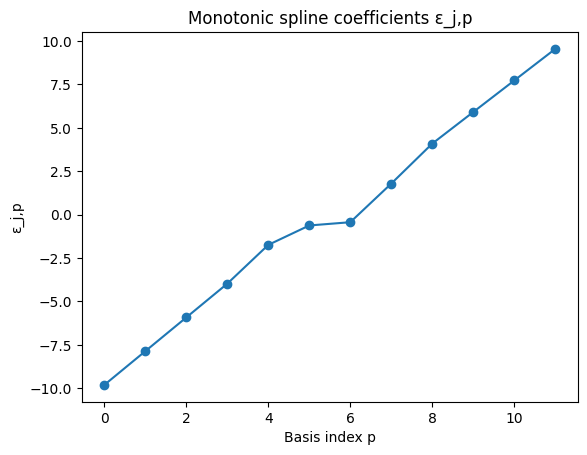

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-8.4473, -8.1130, -5.7330, -3.6320, -1.6367, -0.5480, -0.3897,  1.7734,
         4.2437,  4.2919,  4.2978,  4.3016])


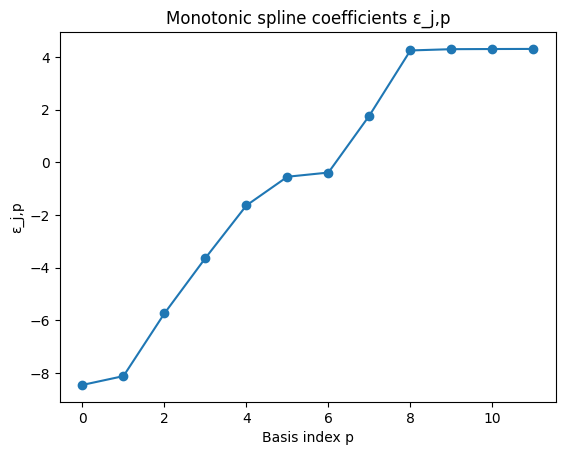

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.9639, -8.1296, -6.2953, -4.4606, -2.5831, -0.5023,  0.9510,  3.4297,
         5.2702,  7.0884,  8.9066, 10.7248])


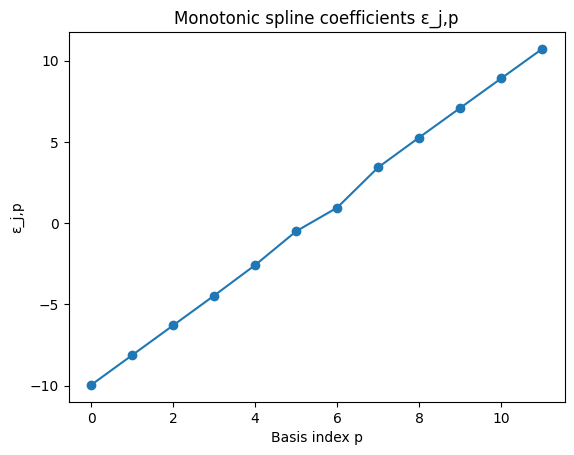

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-8.5459, -8.2343, -6.0003, -4.0698, -2.5404, -0.5785,  0.8742,  3.3903,
         3.4414,  3.4474,  3.4515,  3.4561])


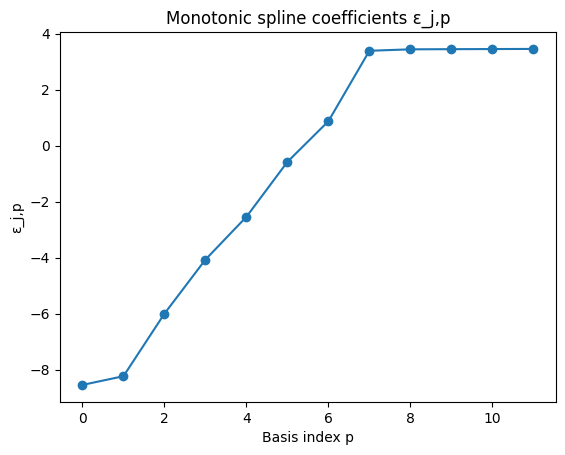

In [31]:
sanity_check(model_freq, transformation_grad=0)
sanity_check(model, transformation_grad=0)
sanity_check(model_freq, transformation_grad=1)
sanity_check(model, transformation_grad=1)

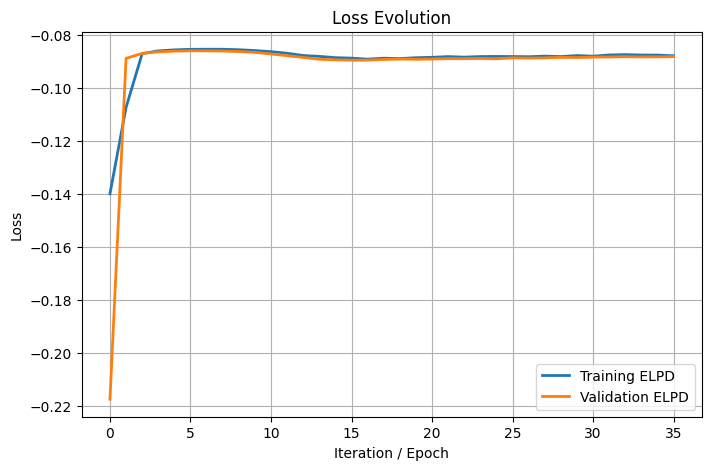

In [32]:
loss_history = output['ll_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Training ELPD", linewidth=2)
plt.plot(val_loss, label="Validation ELPD", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [34]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.1886
KLD GTM      Train Data:  0.1878
KLD Gaussian Train Data:  -0.2636
KLD Copula   Train Data:  0.5218

KLD BGTM      Test  Data:  0.1858
KLD GTM      Test  Data:  0.1842
KLD Gaussian Test  Data:  -0.3068
KLD Copula   Test  Data:  0.5291


In [35]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

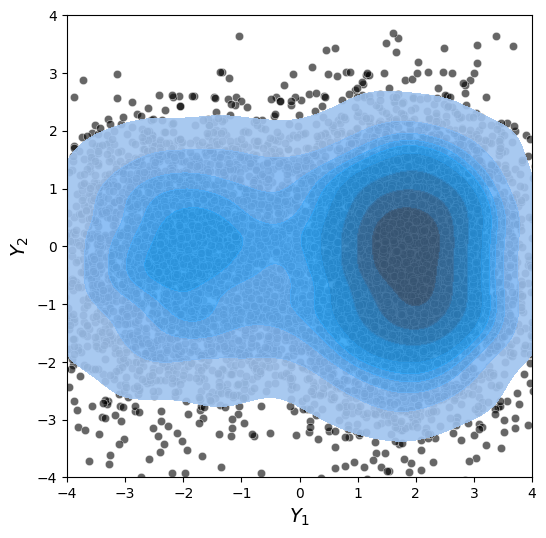

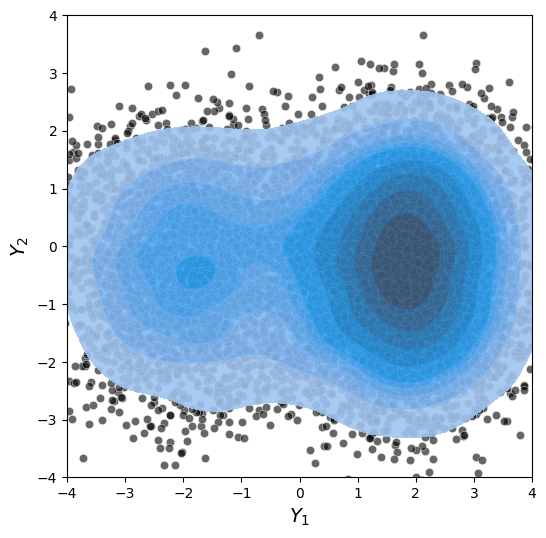

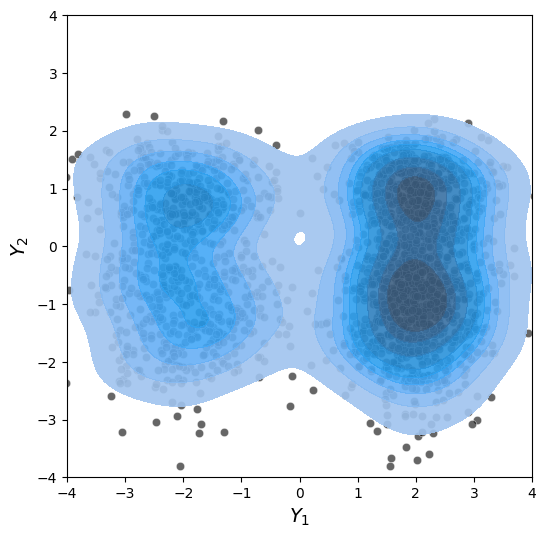

In [36]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])